In [2]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import pickle

%matplotlib inline

In [2]:
def timestep_embedding(timesteps, dim, max_period=1000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """
    def forward(self, x, t_emb, c_emb, mask):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb, c_emb, mask)
            else:
                x = layer(x)
            return x

def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [3]:
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, class_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.class_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_channels, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, t, c, mask):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        `c` has shape `[batch_size, class_dim]`
        `mask` has shape `[batch_size, ]`
        """
        h = self.conv1(x)
        emb_t = self.time_emb(t)
        emb_c = self.class_emb(c)*mask[:, None]
        h += (emb_t[:, :, None, None] + emb_c[:, :, None, None])
        h = self.conv2(h)
        
        return h + self.shortcut(x)

In [4]:
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)
        
    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B *  self.num_heads, -1, H * W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x
    

In [5]:
class UpSample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

class DownSample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, padding=1, stride=2)
        else:
            self.op = nn.AvgPool2d(stride=2)
    
    def forward(self, x):
        return self.op(x)

In [6]:
class Unet(nn.Module):
    def __init__(self, 
                 in_channels=2,
                 model_channels=128,
                 out_channels=2,
                 num_res_blocks=2, 
                 attention_resolutions=(8, 16),
                 dropout=0,
                 channel_mult=(1, 2, 2, 2),
                 conv_resample=True,
                 num_heads=4, 
                 class_num=10):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions,
        self.dropout = dropout
        self.channel_mult = channel_mult,
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        self.class_num = class_num
        
        # time embedding
        time_emb_dim = model_channels*4
        self.time_emb = nn.Sequential(
            nn.Linear(model_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # conditional (class) embedding
        class_emb_dim = model_channels
        self.class_emb = nn.Embedding(class_num, class_emb_dim)
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_channels = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResidualBlock(ch, model_channels*mult, time_emb_dim, class_emb_dim, dropout)]
                ch = model_channels*mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_channels.append(ch)
            if level != len(channel_mult)-1:
                self.down_blocks.append(TimestepEmbedSequential(DownSample(ch, conv_resample)))
                down_block_channels.append(ch)
                ds *= 2
        
        # middle blocks
        self.middle_blocks = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_emb_dim, class_emb_dim, dropout),
            AttentionBlock(ch, num_heads),
            ResidualBlock(ch, ch, time_emb_dim, class_emb_dim, dropout)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in enumerate(channel_mult[::-1]):
            for i in range(num_res_blocks+1):
                layers = [
                    ResidualBlock(ch+down_block_channels.pop(), model_channels*mult, time_emb_dim, class_emb_dim, dropout)
                ]
                ch = model_channels*mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                if level != len(channel_mult)-1 and i == num_res_blocks:
                    layers.append(UpSample(ch, conv_resample))
                    ds //=2
                self.up_blocks.append(TimestepEmbedSequential(*layers))
                
        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(ch, out_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, timesteps, c, mask):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param c: a 1-D batch of classes.
        :param mask: a 1-D batch of conditioned/unconditioned.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step and class embedding
        t_emb = self.time_emb(timestep_embedding(timesteps, dim=self.model_channels))
        c_emb = self.class_emb(c)
        
        # down step
        h = x
        for module in self.down_blocks:
            h = module(h, t_emb, c_emb, mask)
            hs.append(h)
        
        # mid stage
        h = self.middle_blocks(h, t_emb, c_emb, mask)
        
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, t_emb, c_emb, mask)
            
        return self.out(h)

In [7]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def sigmoid_beta_schedule(timesteps):
    betas = torch.linspace(-6, 6, timesteps)
    betas = torch.sigmoid(betas) / (betas.max() - betas.min()) * (0.02 - betas.min()) / 10
    return betas

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [17]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps = 1000,
        beta_schedule = 'linear',
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        elif beta_schedule == 'sigmoid':
            betas = sigmoid_beta_schedule(timesteps)
        else:
            raise ValueError(f'Unknown beta schedule {beta_schedule}')
        
        self.betas = betas
        
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
        )
    
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion : q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # mean and variance of q(x_t | x_0)
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # mean and variance of diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: reverse of q_sample
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t) 
    def p_mean_variance(self, model, x_t, t, c, w, clip_denoised=True):
        device = next(model.parameters()).device
        batch_size = x_t.shape[0]
        
        # noise prediction from model
        pred_noise_c = model(x_t, t, c, torch.ones(batch_size).int().to(device))
        pred_noise_none = model(x_t, t, c, torch.zeros(batch_size).int().to(device))
        pred_noise = (1 + w) * pred_noise_c - w * pred_noise_none
        
        # get predicted x_0
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        
        return model_mean, posterior_variance, posterior_log_variance
    
    # denoise step: sample x_{t-1} from x_t and pred noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, c, w, clip_denoised=True):
        # pred mean and variance
        model_mean, _, model_log_varaince = self.p_mean_variance(model, x_t, t, c, w, clip_denoised=clip_denoised)
        
        noise = torch.randn_like(x_t)
        # no noise when t = 0 
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_varaince).exp() * noise
        return pred_img
    
    # denoise : reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape, n_class=10, w=2, mode='random', clip_denoised=True):
        batch_size = shape[0]
        device = next(model.parameters()).device
        
        # generate labels
        if mode == 'random':
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':
            if batch_size%n_class != 0:
                batch_size = n_class
                print('change batch size to ', n_class)
            cur_y = torch.tensor([x for x in range(n_class)] * (batch_size//n_class), d_type=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)
        
        # start from pure noise
        imgs = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
            img = self.p_sample(model, img, torch.full((batch_size, ), i, device=device, dtype=torch.long), cur_y, w, clip_denoised)
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad
    def sample(self, model, image_size, batch_size=8, channels=3, n_class=10, w=2, mode='random', clip_denoised=True):
        return self.p_sample_loop(model, (batch_size, channels, image_size, image_size), n_class, w, model, clip_denoised)
    
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        n_class = 10,
        w = 2,
        mode= 'random',
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        
        # generate labels
        if mode == 'random':
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':
            if batch_size%n_class!=0:
                batch_size = n_class
                print('change batch_size to', n_class)
            cur_y = torch.tensor([x for x in range(n_class)]*(batch_size//n_class), dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)
        
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        seq_img = [sample_img.cpu().numpy()]   
        
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict noise using model
            pred_noise_c = model(sample_img, t, cur_y, torch.ones(batch_size).int().cuda())
            pred_noise_none = model(sample_img, t, cur_y, torch.zeros(batch_size).int().cuda())
            pred_noise = (1+w)*pred_noise_c - w*pred_noise_none
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            if mode == 'all':
                seq_img.append(sample_img.cpu().numpy())
            
        if mode == 'all':
            return seq_img
        else:
            return sample_img.cpu().numpy()
    
    # compute train losses
    def train_losses(self, model, x_start, t, c, mask_c):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t, c, mask_c)
        loss = F.mse_loss(noise, predicted_noise)
        return loss     
    
    

In [16]:
class ConditionalImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, conditional_offset=5):
        self.data_dir = data_dir
        self.transform = transform
        self.conditional_offset = conditional_offset
        self.data = []
        self._load_data()

    def _load_data(self):
        files = sorted([os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith('.mpy')])
        for file in files:
            with open(file, 'rb') as f:
                images = pickle.load(f)
                if isinstance(images, list):
                    images = np.array(images)
                self.data.append(images)

    def __len__(self):
        return sum(len(images) for images in self.data) - len(self.data) * self.conditional_offset

    def __getitem__(self, idx):
        collection_idx, image_idx = self._get_indices(idx)
        image = self.data[collection_idx][image_idx]
        cond_image = self.data[collection_idx][image_idx - self.conditional_offset]

        if self.transform:
            image = self.transform(image)
            cond_image = self.transform(cond_image)

        return image, cond_image

    def _get_indices(self, idx):
        cumulative_length = 0
        for collection_idx, images in enumerate(self.data):
            collection_length = len(images) - self.conditional_offset
            if idx < cumulative_length + collection_length:
                return collection_idx, idx - cumulative_length + self.conditional_offset
            cumulative_length += collection_length
        raise IndexError(f"Index {idx} out of range")

DATA_DIR = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/bin_frames"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

burn_data = ConditionalImageDataset(DATA_DIR, transform=transform)

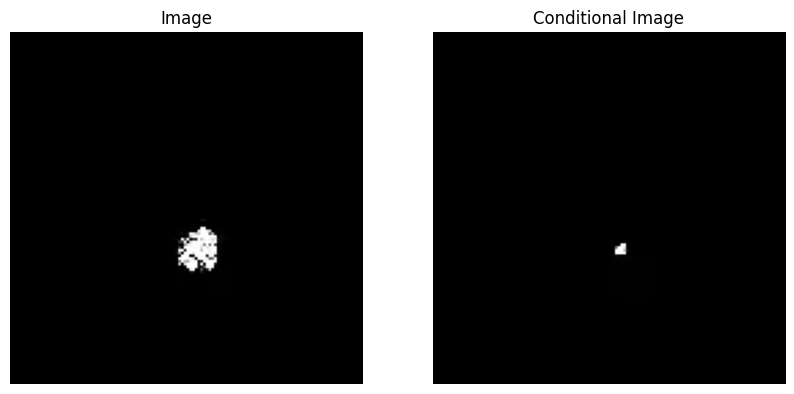

In [26]:
import random 

def plot_random_sample(dataset):
    # Get a random index
    # random_idx = random.randint(0, len(dataset) - 1)
    random_idx = 30
    
    
    # Get the image and conditional image
    image, cond_image = dataset[random_idx]
    
    # Convert to numpy arrays for plotting
    image = image.numpy().transpose(1, 2, 0)  # Transpose from (C, H, W) to (H, W, C)
    cond_image = cond_image.numpy().transpose(1, 2, 0)  # Transpose from (C, H, W) to (H, W, C)
    
    # Denormalize the images
    image = (image * 0.5 + 0.5).clip(0, 1)
    cond_image = (cond_image * 0.5 + 0.5).clip(0, 1)
    
    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("Image")
    axs[0].axis('off')
    
    axs[1].imshow(cond_image, cmap='gray')
    axs[1].set_title("Conditional Image")
    axs[1].axis('off')
    
    plt.show()

# Assuming dataset is already created
plot_random_sample(burn_data)

In [16]:
batch_size = 128
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# MNIST DATA
dataset = datasets.MNIST(root='./dataset/mnist', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    class_num=10
)
model.to(device)

Unet(
  (time_emb): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (class_emb): Embedding(10, 96)
  (down_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResidualBlock(
        (conv1): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (time_emb): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (class_emb): Sequential(
          (0): SiLU()
          (1): Linear(in_features=96, out_features=96, bias=True)
        )
        (conv2): Sequential(
          (0): GroupNorm(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2

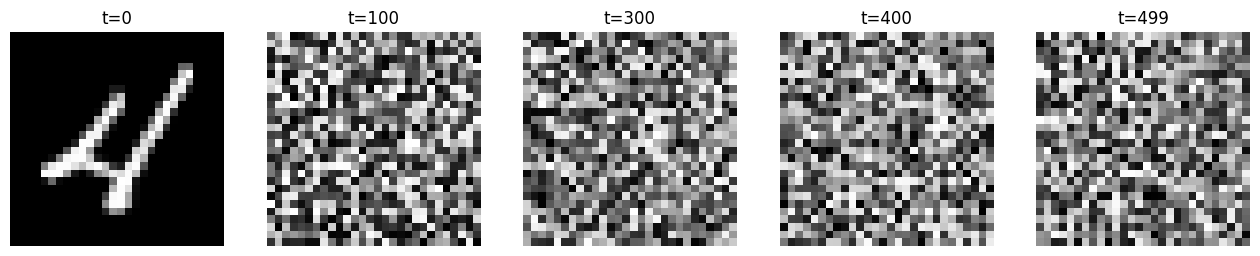

In [18]:
image = next(iter(train_loader))[0][0].squeeze()
label = next(iter(train_loader))[1][0].squeeze()

x_start = image

gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')

plt.figure(figsize=(16, 5))
for idx, t in enumerate([0, 100, 300, 400, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start.to(device), t=torch.tensor([t]).to(device))
    noisy_image = (x_noisy.squeeze() + 1) * 127.5
    if idx==0:
        noisy_image = (x_start.squeeze() + 1) * 127.5
    noisy_image = noisy_image.cpu().numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image, cmap='gray')
    plt.axis("off")
    plt.title(f"t={t}")
    

In [ ]:
# train
epochs = 10
p_uncound = 0.2
len_data = len(train_loader)
time_end = time.time()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader):     
        time_start = time_end
        
        optimizer.zero_grad()
        
        batch_size = images.shape[0]
        images = images.to(device)
        labels = labels.to(device)
        
        # random generate mask
        z_uncound = torch.rand(batch_size)
        batch_mask = (z_uncound>p_uncound).int().to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t, labels, batch_mask)
        
        if step % 100 == 0:
            time_end = time.time()
            print("Epoch{}/{}\t  Step{}/{}\t Loss {:.4f}\t Time {:.2f}".format(epoch+1, epochs, step+1, len_data, loss.item(), time_end-time_start))
            
        loss.backward()
        optimizer.step()

In [ ]:
if not os.path.exists('./saved_models'):
    os.mkdir('./saved_models')
torch.save(model, './saved_models/Classifier_free_DDIM_MNIST.h5')

In [ ]:
model = torch.load('./saved_models/Classifier_free_DDIM_MNIST.h5')
gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')

In [ ]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1, n_class=10, w=2, mode='random', clip_denoised=False)

In [ ]:
# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [ ]:
ddim_generated_images = gaussian_diffusion.ddim_sample(model, 28, batch_size=64, channels=1, ddim_timesteps=50, n_class=10,
                                                       w=2, mode='random', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:
# ddim generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = ddim_generated_images.reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")